<a href="https://colab.research.google.com/github/sungjuGit/STPython_IntroBayes/blob/main/Football_simulation_pymc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converted (partially) from the Julia code by Claude.ai

In [ ]:
import json
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

In [ ]:
# Load the JSON data
with open("matches_England.json", "r") as file:
    england_league = json.load(file)

# Initialize an empty DataFrame
matches_df = pd.DataFrame(columns=['home', 'away', 'score_home', 'score_away'])

# Extract match information
matches = []
for match in england_league:
    matches.append(match["label"].split(","))  # ["Burnley - AFC Bournemouth", "1 - 2"]

# Parse the matches and populate the DataFrame
data = []
for match in matches:
    # Split team names
    teams_part = match[0].strip()
    home, away = teams_part.split(" - ")

    # Split scores
    scores_part = match[1].strip()
    score_home, score_away = scores_part.split(" - ")

    # Add to data list
    data.append([home, away, int(score_home), int(score_away)])

# Create DataFrame from the collected data
matches_df = pd.DataFrame(data, columns=['home', 'away', 'score_home', 'score_away'])

# Get unique teams
teams = np.array(matches_df['home'].unique())

# Display the DataFrame
print(matches_df.head())
print(f"Number of matches: {len(matches_df)}")
print(f"Number of teams: {len(teams)}")
print(f"Teams: {teams}")

                home                    away  score_home  score_away
0            Burnley         AFC Bournemouth           1           2
1     Crystal Palace    West Bromwich Albion           2           0
2  Huddersfield Town                 Arsenal           0           1
3          Liverpool  Brighton & Hove Albion           4           0
4  Manchester United                 Watford           1           0
Number of matches: 380
Number of teams: 20
Teams: ['Burnley' 'Crystal Palace' 'Huddersfield Town' 'Liverpool'
 'Manchester United' 'Newcastle United' 'Southampton' 'Swansea City'
 'Tottenham Hotspur' 'West Ham United' 'Manchester City' 'Leicester City'
 'Chelsea' 'Arsenal' 'Everton' 'AFC Bournemouth' 'Watford'
 'West Bromwich Albion' 'Stoke City' 'Brighton & Hove Albion']


In [ ]:
def football_matches_model(home_teams, away_teams, score_home, score_away, teams):
    """
    PyMC model for predicting football match outcomes
    """
    # Convert team names to indices
    home_team_idx = np.array([np.where(teams == team)[0][0] for team in home_teams])
    away_team_idx = np.array([np.where(teams == team)[0][0] for team in away_teams])

    n_teams = len(teams)

    with pm.Model() as model:
        # Hyper priors
        μatt = pm.Normal("μatt", mu=0, sigma=0.1)
        μdef = pm.Normal("μdef", mu=0, sigma=0.1)
        σatt = pm.Exponential("σatt", lam=1)
        σdef = pm.Exponential("σdef", lam=1)
        home = pm.Normal("home", mu=0, sigma=1)

        # Team-specific effects
        att = pm.Normal("att", mu=μatt, sigma=σatt, shape=n_teams)
        def_ = pm.Normal("def", mu=μdef, sigma=σdef, shape=n_teams)

        # Calculate offset
        offset = pm.Deterministic("offset", att.mean() + def_.mean())

        # Scoring rates for each match
        θ_home = pm.Deterministic(
            "θ_home",
            home + att[home_team_idx] + def_[away_team_idx] - offset
        )
        θ_away = pm.Deterministic(
            "θ_away",
            att[away_team_idx] + def_[home_team_idx] - offset
        )

        # Likelihood
        home_goals = pm.Poisson("home_goals", mu=pm.math.exp(θ_home), observed=score_home)
        away_goals = pm.Poisson("away_goals", mu=pm.math.exp(θ_away), observed=score_away)

    return model

In [ ]:
# Create and sample from the model
def run_model(matches_df, teams):
    home_teams = matches_df.iloc[:, 0].values
    away_teams = matches_df.iloc[:, 1].values
    score_home = matches_df.iloc[:, 2].values
    score_away = matches_df.iloc[:, 3].values

    model = football_matches_model(home_teams, away_teams, score_home, score_away, teams)

    with model:

        # Sample using NUTS (equivalent to the Julia code)
        step = pm.NUTS(target_accept=0.95)
        posterior = pm.sample(5000, step=step, tune=1000)

    return posterior



In [ ]:
posterior = run_model(matches_df, teams)

Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# Processing posterior results
def process_and_visualize(post_chain, teams):

    #posterior_df = az.summary(posterior)

    # Example team comparison
    teamA = "Manchester City"
    teamB = "Manchester United"

    teamA_id = np.where(teams == teamA)[0][0]
    teamB_id = np.where(teams == teamB)[0][0]

    # Extract posterior samples
    teamA_att_post = post_chain.posterior["att"][:, :, teamA_id].values.flatten()
    teamA_def_post = post_chain.posterior["def"][:, :, teamA_id].values.flatten()

    teamB_att_post = post_chain.posterior["att"][:, :, teamB_id].values.flatten()
    teamB_def_post = post_chain.posterior["def"][:, :, teamB_id].values.flatten()

    # Plot attack distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.histplot(teamA_att_post, kde=True, ax=ax1)
    ax1.set_title(f"{teamA} attack", fontsize=12)
    ax1.set_xlabel("Attack power")
    ax1.set_ylabel("Probability density")

    sns.histplot(teamB_att_post, kde=True, ax=ax2)
    ax2.set_title(f"{teamB} attack", fontsize=12)
    ax2.set_xlabel("Attack power")
    ax2.set_ylabel("Probability density")

    plt.tight_layout()
    plt.show()

    # Plot defense distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.histplot(teamA_def_post, kde=True, ax=ax1)
    ax1.set_title(f"{teamA} defense", fontsize=12)
    ax1.set_xlabel("Defense power")
    ax1.set_ylabel("Probability density")

    sns.histplot(teamB_def_post, kde=True, ax=ax2)
    ax2.set_title(f"{teamB} defense", fontsize=12)
    ax2.set_xlabel("Defense power")
    ax2.set_ylabel("Probability density")

    plt.tight_layout()
    plt.show()

    return {
        "teamA_att": teamA_att_post,
        "teamA_def": teamA_def_post,
        "teamB_att": teamB_att_post,
        "teamB_def": teamB_def_post
    }


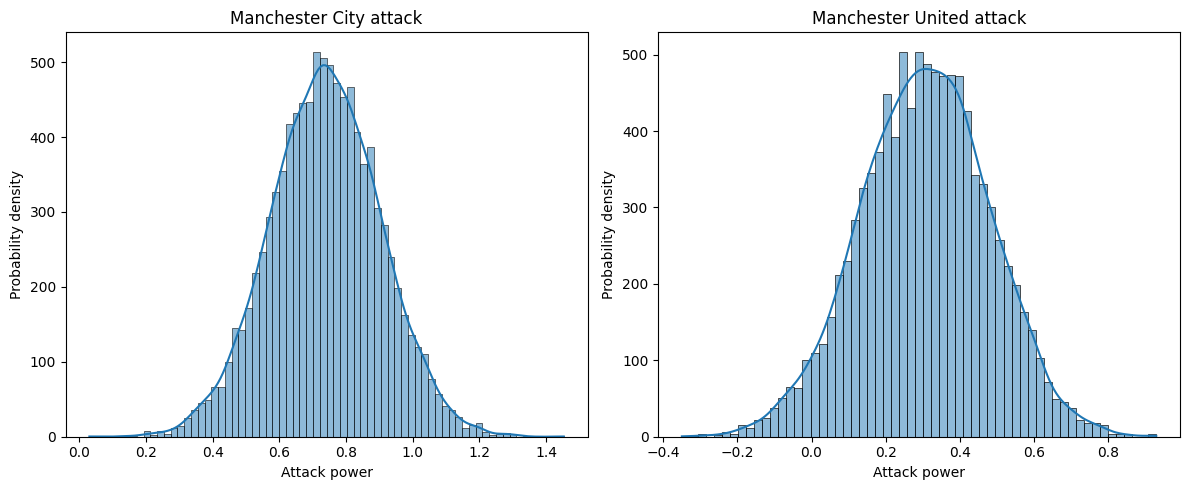

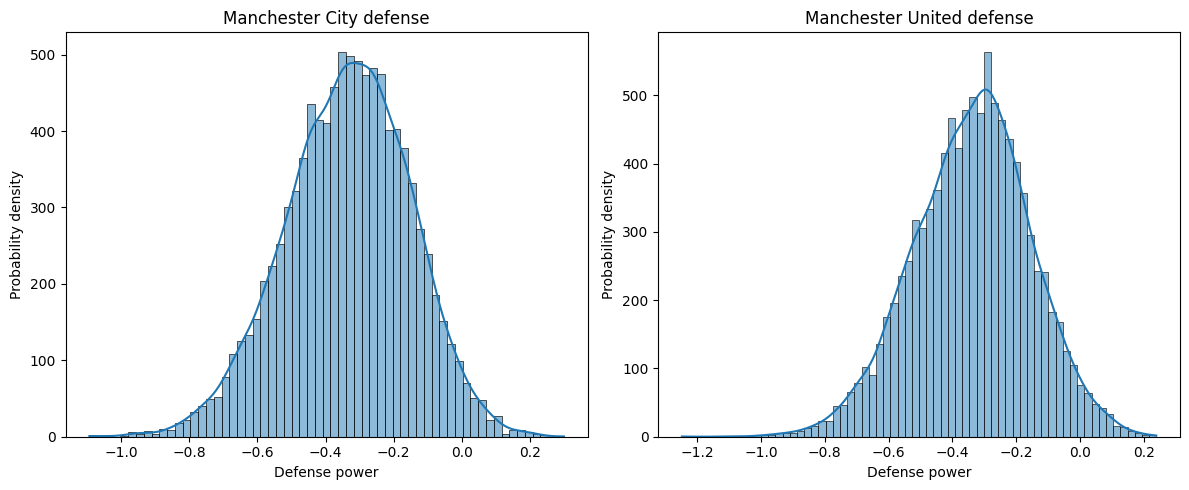

In [ ]:
results = process_and_visualize(posterior, teams)

### Simulate Matches (Example Codes when you are stuck)

In [ ]:
def simulate_match(post_chain, teamA, teamB, teams, n_simulations=500):
    """
    Simulate match scores between two teams using posterior samples

    Parameters:
    -----------
    posterior : arviz.InferenceData
        The posterior samples from PyMC
    teamA : str
        Name of the home team
    teamB : str
        Name of the away team
    teams : array-like
        Array of team names
    n_simulations : int
        Number of simulations to run

    Returns:
    --------
    dict : Dictionary with simulated scores and win probabilities
    """
    # Get team indices
    teamA_id = np.where(teams == teamA)[0][0]
    teamB_id = np.where(teams == teamB)[0][0]

    # Extract posterior samples
    # Flatten chains and draws
    home_effect = np.concatenate(post_chain.posterior["home"].values)
    teamA_att = np.concatenate(post_chain.posterior["att"][:, :, teamA_id].values)
    teamB_def = np.concatenate(post_chain.posterior["def"][:, :, teamB_id].values)
    offset = np.concatenate(post_chain.posterior["offset"].values)

    teamB_att = np.concatenate(post_chain.posterior["att"][:, :, teamB_id].values)
    teamA_def = np.concatenate(post_chain.posterior["def"][:, :, teamA_id].values)

    # Calculate theta (log scoring rate) for both teams
    θ_home = home_effect + teamA_att + teamB_def - offset
    θ_away = teamB_att + teamA_def - offset

    # Generate random samples from Poisson distributions
    teamA_score_samples = np.array([
        poisson.rvs(np.exp(rate), size=n_simulations) for rate in θ_home
    ]).flatten()

    teamB_score_samples = np.array([
        poisson.rvs(np.exp(rate), size=n_simulations) for rate in θ_away
    ]).flatten()

    # Calculate match outcome probabilities
    total_sims = len(teamA_score_samples)
    teamA_wins = np.sum(teamA_score_samples > teamB_score_samples) / total_sims
    teamB_wins = np.sum(teamB_score_samples > teamA_score_samples) / total_sims
    draws = np.sum(teamA_score_samples == teamB_score_samples) / total_sims

    # Create a frequency table of scores
    max_goals = max(np.max(teamA_score_samples), np.max(teamB_score_samples))
    score_matrix = np.zeros((max_goals+1, max_goals+1))

    for i in range(len(teamA_score_samples)):
        score_matrix[teamA_score_samples[i], teamB_score_samples[i]] += 1

    score_matrix = score_matrix / total_sims  # Convert to probabilities

    return {
        "teamA_scores": teamA_score_samples,
        "teamB_scores": teamB_score_samples,
        "score_matrix": score_matrix,
        "teamA_win_prob": teamA_wins,
        "teamB_win_prob": teamB_wins,
        "draw_prob": draws
    }


In [ ]:
def plot_score_distribution(results, teamA, teamB):
    """
    Visualize the simulated score distributions
    """

    # Plot the score matrix as a heatmap
    plt.figure(figsize=(10, 8))
    max_display = 5  # Only show up to 5 goals for readability

    # Create score labels
    score_labels = [str(i) for i in range(min(max_display+1, results["score_matrix"].shape[0]))]

    # Slice the matrix to show only scores up to max_display
    display_matrix = results["score_matrix"][:max_display+1, :max_display+1]

    # Create heatmap
    ax = sns.heatmap(
        display_matrix,
        annot=True,
        fmt='.3f',
        cmap='Blues',
        xticklabels=score_labels,
        yticklabels=score_labels
    )

    plt.xlabel(f'{teamB} Score')
    plt.ylabel(f'{teamA} Score')
    plt.title(f'Probability Distribution of Match Scores\n{teamA} vs {teamB}')

    # Create a text box with match outcome probabilities
    textbox = (
        f"{teamA} win: {results['teamA_win_prob']:.2f}\n"
        f"Draw: {results['draw_prob']:.2f}\n"
        f"{teamB} win: {results['teamB_win_prob']:.2f}"
    )

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.figtext(0.15, 0.15, textbox, bbox=props)

    plt.tight_layout()
    plt.show()

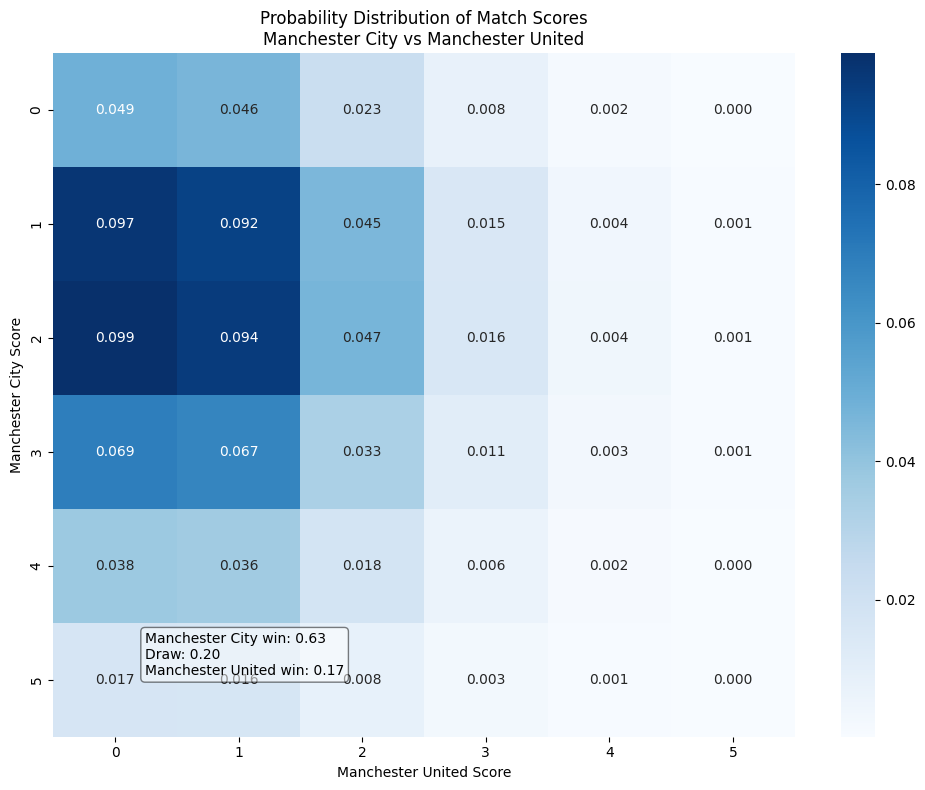

In [ ]:
teamA = "Manchester City"
teamB = "Manchester United"
results = simulate_match(posterior, teamA, teamB, teams)
plot_score_distribution(results, teamA, teamB)